In [ ]:
# !pip install qiskit
# !pip install pylatexenc
# !pip install qiskit_aer

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace, Operator
import numpy as np
import matplotlib.pyplot as plt

##### You are allowed to use other libraries for the bloch sphere visualization, instead of qiskit.visualization.
from qiskit.visualization import plot_bloch_vector ## Don't need this one? comment it out!
###### Do you need more libraries for visualization? Import them! :)

In [ ]:
# Step 1: Initialize a quantum circuit with 3 qubits (no classical bits needed for statevector simulation)
qc = QuantumCircuit(3)


In [ ]:

# Step 2: Prepare the state to teleport (qubit 0) — simulate classical input (like in superdense coding)
# Let's define a parameterized input state based on two classical bits (00, 01, 10, 11)
input_bits = '10'  # Change this to '00', '01', '10', or '11' to test other cases

if input_bits == '00':
    pass  # |0>
elif input_bits == '01':
    qc.x(0)  # |1>
elif input_bits == '10':
    qc.h(0)  # |+>
elif input_bits == '11':
    qc.x(0)
    qc.h(0)  # |->


In [ ]:

# Step 3: Create entanglement between qubit 1 and 2 (shared EPR pair between Alice and Bob)
qc.h(1)
qc.cx(1, 2)


In [ ]:

# Step 4: Bell-state measurement on Alice's qubits (0 and 1)
qc.cx(0, 1)
qc.h(0)


In [ ]:

# Step 5: Simulate the circuit up to this point (before measurement and classical corrections)
# We will manually apply corrections to the statevector based on the expected measurement outcomes

# Simulate to get statevector before measurement
initial_state_before_measurement = Statevector.from_instruction(qc)

# Display the statevector before measurement (optional)
print("Statevector before measurement and correction:")
print(initial_state_before_measurement)


Statevector before measurement and correction:
Statevector([ 0.35355339+0.j,  0.35355339+0.j,  0.35355339+0.j,
             -0.35355339+0.j,  0.35355339+0.j, -0.35355339+0.j,
              0.35355339+0.j,  0.35355339+0.j],
            dims=(2, 2, 2))


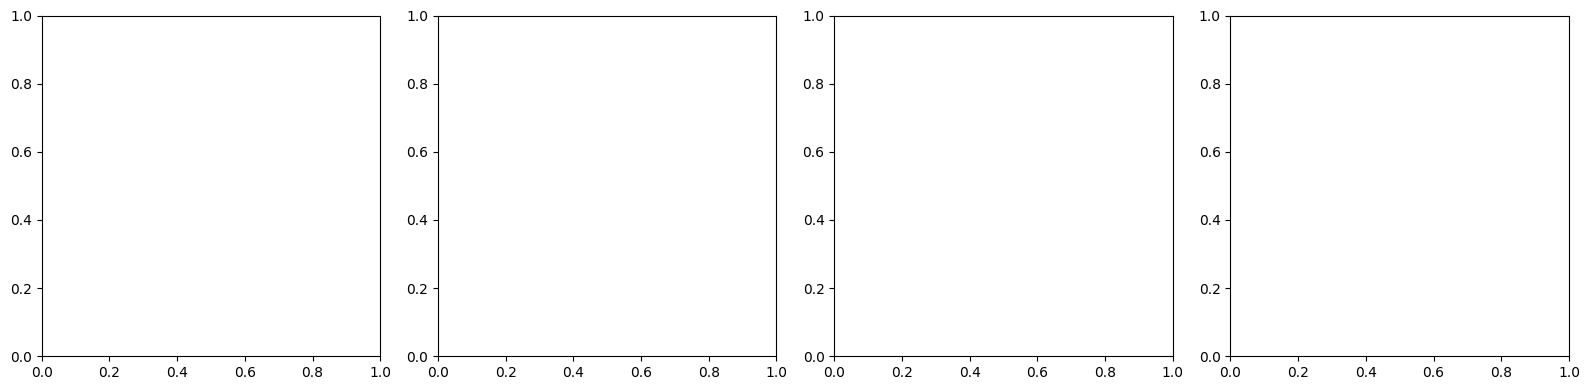

In [ ]:

# Step 6: Manually apply corrections to qubit 2 depending on the *expected* measurement result
# We'll project the statevector onto each possible measurement outcome and apply the corresponding correction

def apply_correction(meas_result, statevec):
    qc_corr = QuantumCircuit(3)
    if meas_result == '00':
        pass
    elif meas_result == '01':
        qc_corr.x(2)
    elif meas_result == '10':
        qc_corr.z(2)
    elif meas_result == '11':
        qc_corr.x(2)
        qc_corr.z(2)
    return statevec.evolve(qc_corr)

# Possible measurement outcomes for qubits 0 and 1
possible_measurements = ['00', '01', '10', '11']
corrected_states = {}

for meas in possible_measurements:
    # Manually project statevector onto each measurement outcome (qubits 0 and 1)
    # Keep the components of the statevector where qubits 0 and 1 match the measurement outcome
    proj_state_data = np.zeros_like(initial_state_before_measurement.data)
    # Qiskit uses little-endian ordering for qubits in the statevector, so the binary
    # representation of the index i is ordered as q(n-1) ... q2 q1 q0.
    # We are projecting on qubits 0 and 1, which are the last two bits in this ordering.
    # The measurement outcome 'meas' is given as 'q0q1'.
    # So, if meas = '01', we are looking for indices where the last two bits (q1 q0) are '10' (binary representation of 2).
    meas_value_bin_qiskit_order = meas[::-1] # Reverse 'q0q1' to 'q1q0' to match the order in the binary representation of the index

    for i in range(2**qc.num_qubits):
        binary_repr = bin(i)[2:].zfill(qc.num_qubits)
        # Extract bits for qubits 0 and 1 (q1 q0) from the binary representation of the index
        qubit_0_1_bits_from_index = binary_repr[-2:]

        if qubit_0_1_bits_from_index == meas_value_bin_qiskit_order:
            proj_state_data[i] = initial_state_before_measurement.data[i]

    # Create a new Statevector from the projected data
    proj_state = Statevector(proj_state_data)

    # Normalize the projected state (if it's not the zero vector)
    norm = np.linalg.norm(proj_state.data)
    if norm > 1e-9: # Use a small tolerance to avoid division by zero
        normalized_proj_state = proj_state / norm
        corrected = apply_correction(meas, normalized_proj_state)
        corrected_states[meas] = corrected
    else:
        # Handle cases where the projection results in a zero vector (this outcome is not possible)
        print(f"Projection for measurement {meas} resulted in a zero vector. Skipping.")


# Define Pauli operators as Operators
X_op = Operator([[0, 1], [1, 0]])
Y_op = Operator([[0, -1j], [1j, 0]])
Z_op = Operator([[1, 0], [0, -1]])

# Plot Bloch vectors of corrected qubit (Bob’s qubit 2) for each case
fig, axs = plt.subplots(1, len(corrected_states), figsize=(4 * len(corrected_states), 4))
for i, (meas, state) in enumerate(corrected_states.items()):
    # Trace out Alice's qubits (0 and 1) to get the reduced density matrix for qubit 2
    rho = partial_trace(state, [0,1])
    # Calculate Bloch vector components from the reduced density matrix using expectation_value
    bloch = [np.real(rho.expectation_value(X_op)),
             np.real(rho.expectation_value(Y_op)),
             np.real(rho.expectation_value(Z_op))]
    # plot_bloch_vector(bloch, title=f"After correction\n(meas={meas})", ax=axs[i])
plt.tight_layout()
plt.show()

In [ ]:
from qiskit import ClassicalRegister

print("\n=== Interference Analysis via Hadamard on Bob's Qubit ===")
for meas, state in corrected_states.items():
    # Create a new circuit to apply H and measure qubit 2
    qc_intf = QuantumCircuit(3, 1)
    qc_intf.set_statevector(state)
    qc_intf.h(2)
    qc_intf.measure(2, 0)

    # Simulate measurement
    backend = AerSimulator()
    t_qc_intf = transpile(qc_intf, backend)
    result = backend.run(t_qc_intf, shots=1000).result()
    counts = result.get_counts()

    print(f"Measurement = {meas} → Interference result on Bob's qubit after H: {counts}")



=== Interference Analysis via Hadamard on Bob's Qubit ===
Measurement = 00 → Interference result on Bob's qubit after H: {'0': 1000}
Measurement = 01 → Interference result on Bob's qubit after H: {'0': 1000}
Measurement = 10 → Interference result on Bob's qubit after H: {'0': 1000}
Measurement = 11 → Interference result on Bob's qubit after H: {'0': 1000}
